### Import libraries

In [1]:
import pandas as pd
import numpy as np
from joblib import load
import shap 
from sklearn.model_selection import train_test_split

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Load pipeline

In [5]:
pipelinepath = '../pipelines/M_6weeks_ENS_model_allfeatures_calibrated.pkl'
pipeline = load(open(pipelinepath, "rb"))

### Load dataset 

In [6]:
dataset = pd.read_csv("../data/dataset_for_training.csv", header=0)
y = dataset["y"]
X = dataset.drop(["y"], axis=1)
categorical_features = list(X.select_dtypes(include=["object"]))
categorical_indices = [X.columns.get_loc(cat) for cat in categorical_features]
continuous_features = list(X.select_dtypes(include=["float", "int"]))
continuous_indices = [X.columns.get_loc(cont) for cont in continuous_features]
features = X.columns

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,stratify=y,random_state=7) ### you can change the random state according to your dataset

### Transform data with pipeline preprocessing steps

In [7]:
X_train_processed = pipeline.named_steps["preprocess"].transform(X_train)
X_test_processed = pipeline.named_steps["preprocess"].transform(X_test)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=pipeline[:-1].get_feature_names_out())
print(X_test_processed_df.iloc[0])

scal__age                               -0.714286
scal__diff_diag_baseline_in_weeks        0.333333
scal__who_score_at_diagnosis             0.000000
scal__hemoglobin                         0.478261
scal__calcium                            0.937500
scal__LDH                                3.000000
scal__CRP                                0.289655
scal__thrombocytes                       1.143411
scal__CKD_EPI                            0.214286
scal__FEV_1_predicted_percentage         0.000000
scal__bmi                               -1.245009
scal__leukocytes                        -0.238994
cat__mutation_yes                        0.000000
cat__gender_V                            0.000000
cat__uses_strong_opioids_yes             1.000000
cat__histology_Small cell lung cancer    1.000000
cat__stage_IV                            1.000000
cat__Cancer_yes                          0.000000
cat__Heart_diseases_yes                  0.000000
cat__CKD_yes                             0.000000


In [8]:
explainer = shap.Explainer(pipeline.named_steps["model"].predict_proba, X_train_processed)
shap_values = explainer(X_test_processed_df.iloc[:5].values) # only processing 5 samples because the explainer takes a while to calculate the shap values

Permutation explainer: 6it [00:19,  4.76s/it]                       


In [9]:
shap_value_sum = np.sum(shap_values.values[0], axis=0)
print(shap_value_sum)

[ 0.13112925 -0.13112925]


In [10]:
expected_value_negative_class = shap_values.base_values[0][0]
expected_value_positive_class = shap_values.base_values[0][1]
print(expected_value_negative_class, expected_value_positive_class)

0.6715857112358019 0.3284142887641982


In [11]:
yprob = pipeline.predict_proba(X_test)[0]
print(yprob)

[0.80271496 0.19728504]


In [12]:
y0 = expected_value_negative_class + shap_value_sum[0] 
y1 = expected_value_positive_class + shap_value_sum[1] 
print(y0,y1)

0.8027149615414073 0.19728503845859285


As you can see, the sum of the expected value (= base_values) and the sum of the shap_values is equal to the predicted probability by the pipeline

### Shap plots

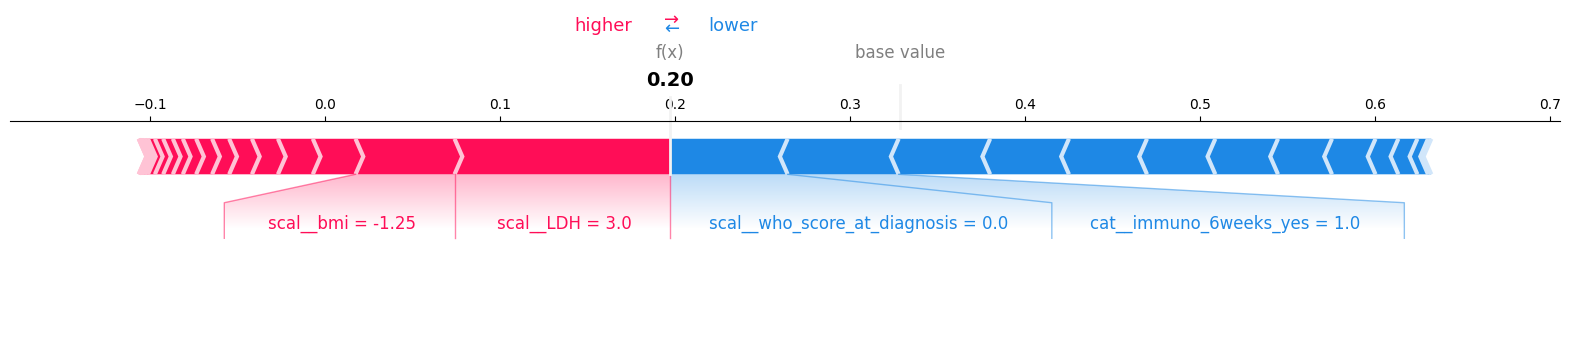

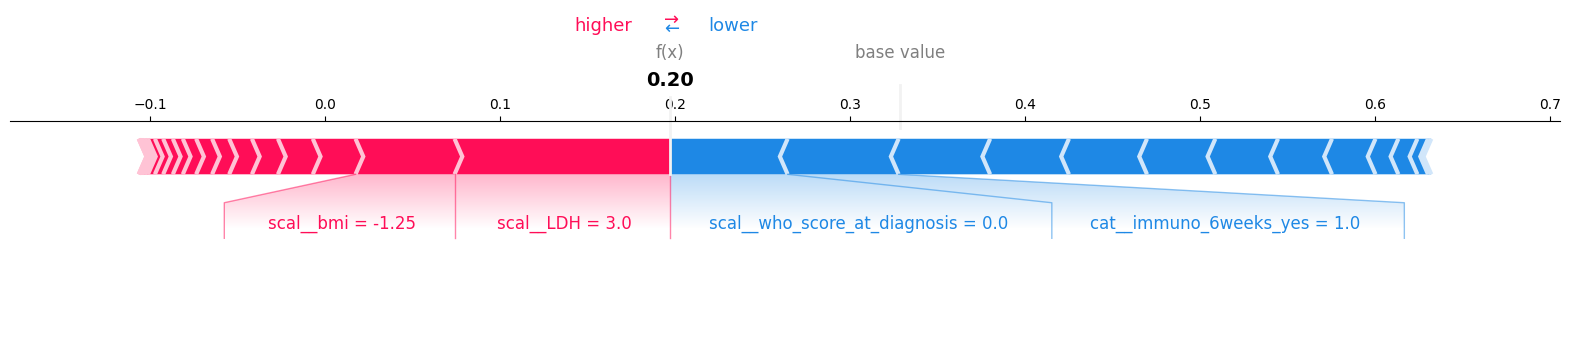

In [13]:
shap.force_plot(
                expected_value_positive_class,
                np.array(shap_values.values[0][:,1]),
                round(X_test_processed_df.iloc[0],2),
                show=False,
                matplotlib=True,
            )

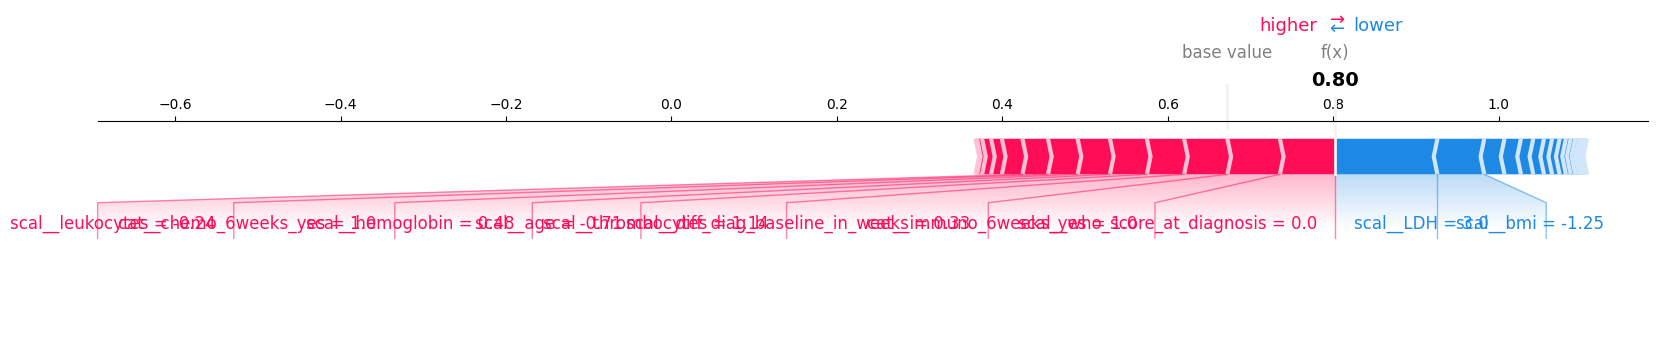

In [15]:
shap.force_plot(
                expected_value_negative_class,
                np.array(shap_values.values[0][:,0]),
                round(X_test_processed_df.iloc[0],2),
                show=False,
                matplotlib=True,
              
            )